In [17]:
### This notebook is not used in the paper but for some presentations of the results
import pickle
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, roc_curve
import os
import config
import seaborn as sns
import matplotlib.pyplot as plt
print(os.getcwd())

/notebooks/uncertainty_prompt_models


In [10]:
run_name = 'leafy-elevator-37'
model_name = 'opt-13b'
ds_name = 'coqa'

def get_similarities_df():
    """Get the similarities df from the pickle file"""
    with open(f'{config.output_dir}/{run_name}/{model_name}_generations_similarities.pkl', 'rb') as f:
        similarities = pickle.load(f)
        similarities_df = pd.DataFrame.from_dict(similarities, orient='index')
        similarities_df['id'] = similarities_df.index
        similarities_df['has_semantically_different_answers'] = similarities_df[
            'has_semantically_different_answers'].astype('int')
        similarities_df['rougeL_among_generations'] = similarities_df['syntactic_similarities'].apply(
            lambda x: x['rougeL'])

        return similarities_df

def get_variances_df():
    with open(f'{config.output_dir}/{run_name}/{model_name}_kernel_entropies.pkl', 'rb') as infile:
        variances_df = pickle.load(infile)
        #variances_df = pd.DataFrame(variances_df)
        #variances_df['id'] = variances_df['id'].apply(lambda x: x[0])
        #variances_df['id'] = variances_df['id'].astype('object')

        return variances_df

def get_generations_df():
    """Get the generations df from the pickle file"""
    with open(f'{config.output_dir}/{run_name}/{model_name}_generations.pkl', 'rb') as infile:
        generations = pickle.load(infile)
        generations_df = pd.DataFrame(generations)
        generations_df['id'] = generations_df['id'].apply(lambda x: x[0])
        generations_df['id'] = generations_df['id'].astype('object')
        if not generations_df['semantic_variability_reference_answers'].isnull().values.any():
            generations_df['semantic_variability_reference_answers'] = generations_df[
                'semantic_variability_reference_answers'].apply(lambda x: x[0].item())

        if not generations_df['rougeL_reference_answers'].isnull().values.any():
            generations_df['rougeL_reference_answers'] = generations_df['rougeL_reference_answers'].apply(
                lambda x: x[0].item())
        generations_df['length_of_most_likely_generation'] = generations_df['most_likely_generation'].apply(
            lambda x: len(str(x).split(' ')))
        generations_df['length_of_answer'] = generations_df['answer'].apply(lambda x: len(str(x).split(' ')))
        generations_df['variance_of_length_of_generations'] = generations_df['generated_texts'].apply(
            lambda x: np.var([len(str(y).split(' ')) for y in x]))
        generations_df['correct'] = (generations_df['rougeL_to_target'] > 0.3).astype('int')

        return generations_df

def get_likelihoods_df():
    """Get the likelihoods df from the pickle file"""

    with open(f'{config.output_dir}/{run_name}/aggregated_likelihoods_{model_name}_generations.pkl', 'rb') as f:
        likelihoods = pickle.load(f)
        #print(likelihoods.keys())

        subset_keys = ['average_predictive_entropy_on_subset_' + str(i) for i in range(1, num_generations + 1)]
        subset_keys += ['predictive_entropy_on_subset_' + str(i) for i in range(1, num_generations + 1)]
        subset_keys += ['semantic_predictive_entropy_on_subset_' + str(i) for i in range(1, num_generations + 1)]
        subset_keys += ['number_of_semantic_sets_on_subset_' + str(i) for i in range(1, num_generations + 1)]

        keys_to_use = ('ids', 'predictive_entropy', 'mutual_information', 'average_predictive_entropy',\
                        'average_pointwise_mutual_information', 'average_neg_log_likelihood_of_most_likely_gen',\
                        'average_neg_log_likelihood_of_second_most_likely_gen', 'neg_log_likelihood_of_most_likely_gen',\
                        'predictive_entropy_over_concepts', 'number_of_semantic_sets', 'unnormalised_entropy_over_concepts')

        likelihoods_small = dict((k, likelihoods[k]) for k in keys_to_use + tuple(subset_keys))
        for key in likelihoods_small:
            if key == 'average_predictive_entropy_on_subsets':
                likelihoods_small[key].shape
            if type(likelihoods_small[key]) is torch.Tensor:
                likelihoods_small[key] = torch.squeeze(likelihoods_small[key].cpu())

        sequence_embeddings = likelihoods['sequence_embeddings']

        likelihoods_df = pd.DataFrame.from_dict(likelihoods_small)

        likelihoods_df.rename(columns={'ids': 'id'}, inplace=True)

        return likelihoods_df, sequence_embeddings

similarities_df = get_similarities_df()
generations_df = get_generations_df()
variances_df = get_variances_df()
num_generations = len(generations_df['generated_texts'][0])
likelihoods_df, sequence_embeddings = get_likelihoods_df()
# this does not multiply the duplicates (similarities_df does have no duplicates)
#result_df = generations_df.merge(similarities_df, on='id')
# this doubles the duplicates (likelihoods_df does have duplicates)
# this was used in the original code and affects the results!
#result_df = result_df.merge(likelihoods_df, on='id')
# instead, we simply concat the dataframes column wise; this works since the rows have the same order
# we can confirm the ordering via (generations_df['id'] == variances_df['id']).all() and (generations_df['id'] == likelihoods_df['id']).all()
result_df = pd.concat([generations_df, likelihoods_df.drop('id', axis=1), variances_df.drop('id', axis=1)], axis=1)
result_df = result_df.merge(similarities_df, on='id')

n_samples_before_filtering = len(result_df)
result_df['len_most_likely_generation_length'] = result_df['most_likely_generation'].apply(lambda x: len(x.split()))

# Begin analysis
result_dict = {}
result_dict['accuracy'] = result_df['correct'].mean()

### Remove NaNs (why wasnt this in original implementation?)
result_df = result_df[result_df['average_predictive_entropy'].notnull()]

print(result_df.columns)

Index(['prompt', 'generations', 'id', 'question', 'generated_texts',
       'most_likely_generation_ids', 'most_likely_generation',
       'second_most_likely_generation_ids', 'second_most_likely_generation',
       'semantic_variability_reference_answers',
       ...
       'k_entropy_cos_e5-small-v2', 'k_entropy_rbf_e5-small-v2',
       'embeddings_gte-large', 'k_entropy_cos_gte-large',
       'k_entropy_rbf_gte-large', 'syntactic_similarities',
       'has_semantically_different_answers', 'semantic_set_ids',
       'rougeL_among_generations', 'len_most_likely_generation_length'],
      dtype='object', length=135)


In [12]:
key = 'k_entropy_rbf_e5-small-v2'
auroc = sklearn.metrics.roc_auc_score(1 - result_df['correct'], result_df[key])
fpr, tpr, thresholds = sklearn.metrics.roc_curve(1 - result_df['correct'], result_df[key])

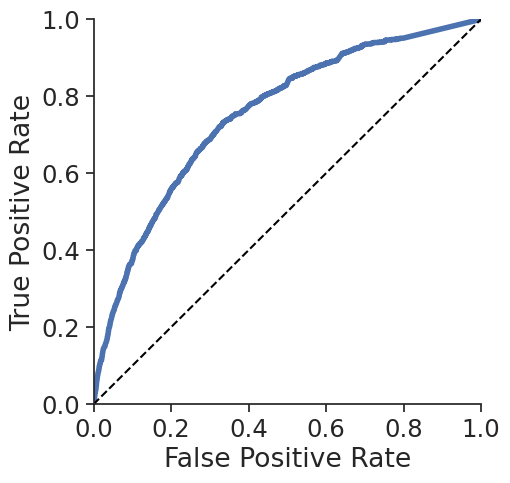

In [29]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.6)
sns.set_style('ticks')
line_size = 4

plot = sns.lineplot(y=tpr, x=fpr, linewidth=line_size)
plot.axline([0,0], [1,1], color='black', linestyle='--')
sns.despine(plot.figure)
plot.set_xlabel("False Positive Rate")
plot.set_ylabel("True Positive Rate")
plot.set_ylim(0,1)
plot.set_xlim(0,1)
plot.figure.savefig('plots/roc_curve.pdf', bbox_inches='tight')
plot.figure.show();